In [1]:
import torch as t
from torch.autograd import Variable
t.set_grad_enabled(True)
import shap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import os.path
from os import path

shap.initjs()

In [2]:
from src.caseDataset import CaseDataset
from src.neuralNetwork import *

In [3]:
caseType = 1
txtSubname = 'contiPositiveAge'
oldData = pd.read_csv('./data/oldData{}.csv'.format(txtSubname)).iloc[:, 1:]
youngData = pd.read_csv('./data/youngData{}.csv'.format(txtSubname)).iloc[:, 1:]
totalData = pd.read_csv('./data/totalData{}.csv'.format(txtSubname)).iloc[:, 1:]
coef = np.loadtxt('./data/coef.txt')
A, B, C, D = coef[0], coef[1], coef[2], coef[3]
totalData

,T,Age,AgeTag,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
0,1.0,0.28,-1.0,1.0,195.0,-65.0,199.966616,-72.963256,139.2,69.2,140.091105,66.638198,139.2,16.0,129.987863,19.166564
1,1.0,0.14,-1.0,1.0,195.0,-65.0,188.534435,-57.193869,119.6,49.6,121.403808,46.406782,119.6,23.0,127.079184,19.969171
2,-1.0,0.70,1.0,-1.0,-5.0,-125.0,-9.382402,-128.791270,-135.0,-65.0,-136.436100,-75.735351,-135.0,68.0,-140.986203,68.859754
3,1.0,0.04,-1.0,-1.0,-125.0,-5.0,-125.697061,-1.522448,-32.0,-102.0,-18.223095,-99.601897,-24.4,-102.0,-30.161104,-108.893942
4,1.0,0.18,-1.0,-1.0,-125.0,-5.0,-118.179846,-5.754429,-39.0,-109.0,-38.967583,-110.765390,-4.8,-109.0,2.005894,-106.929829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.0,0.98,1.0,-1.0,-5.0,-125.0,-7.057795,-130.890330,-149.0,-79.0,-145.511445,-72.952934,-149.0,107.2,-148.429670,103.788289
996,1.0,0.08,-1.0,-1.0,-125.0,-5.0,-123.763853,2.148185,-34.0,-104.0,-34.648330,-107.626314,-18.8,-104.0,-29.520529,-107.023702
997,1.0,0.08,-1.0,1.0,195.0,-65.0,190.409335,-71.021671,111.2,41.2,112.865682,39.057151,111.2,26.0,119.830089,23.074255
998,1.0,0.40,-1.0,1.0,195.0,-65.0,191.676938,-64.637119,156.0,86.0,155.196624,76.073283,156.0,10.0,157.932497,15.167533


In [4]:
totalCaseData = CaseDataset(totalData, caseType=caseType)

## Loading model

In [5]:
PATH="./modelStorage/case{}Model{}.pth".format(caseType, txtSubname)
model = NeuralNetwork()
model.load_state_dict(t.load(PATH))
model.eval()

NeuralNetwork(
  (linearLayer): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [6]:
print(totalCaseData.feature)

[[ 1.    1.    0.28]
 [ 1.    1.    0.14]
 [-1.   -1.    0.7 ]
 ...
 [ 1.    1.    0.08]
 [ 1.    1.    0.4 ]
 [ 1.    1.    0.12]]


In [7]:
# explain predictions of the model on four images
e = shap.DeepExplainer(model, Variable(t.from_numpy(totalCaseData.feature).float()))

In [8]:
if path.isfile('shapValue/shapValueCase{}_{}.npy'.format(caseType, txtSubname)):
    shap_values = np.load('shapValue/shapValueCase{}_{}.npy'.format(caseType, txtSubname))
    print('load from shapValue/shapValueCase{}_{}.npy'.format(caseType, txtSubname))
else:
    print('evaluate SHAP value')
    shap_values = e.shap_values(Variable(t.from_numpy(totalCaseData.feature).float()))
print(shap_values.shape)

load from shapValue/shapValueCase1_contiPositiveAge.npy
(1000, 3)


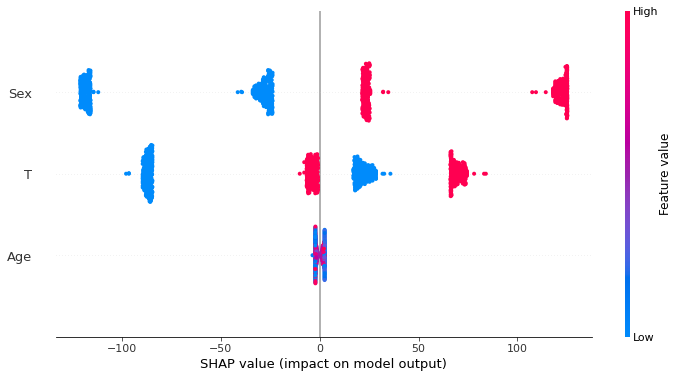

In [9]:
shap.summary_plot(shap_values, totalCaseData.feature, ['T', 'Sex', 'Age'], plot_size=(12, 6))

In [10]:
features = pd.DataFrame(totalCaseData.feature)
features = features.rename(columns={0:'T', 1:'Sex', 2:'Age'})
features

,T,Sex,Age
0,1.0,1.0,0.28
1,1.0,1.0,0.14
2,-1.0,-1.0,0.70
3,1.0,-1.0,0.04
4,1.0,-1.0,0.18
...,...,...,...
995,-1.0,-1.0,0.98
996,1.0,-1.0,0.08
997,1.0,1.0,0.08
998,1.0,1.0,0.40


In [11]:
def dependence_plot(idx, features, shap_values, cbarIdx=None, featureName=None, title=None):
    columnName = list(features.columns)
    norm=plt.Normalize(-1,1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#1e88e5", "#f52757"])
    fig = plt.figure(figsize=(10, 8))
    if not isinstance(cbarIdx, int):
        cbarIdx = idx
    plt.scatter(features.iloc[:, idx], shap_values[:, idx], c=features.iloc[:, cbarIdx], cmap=cmap, s=50)
    cbar = plt.colorbar()
    cbar.set_label('{}'.format(columnName[cbarIdx]), rotation=270, fontsize=20, labelpad=20)
    cbarMin, cbarMax = np.min(features.iloc[:, cbarIdx]), np.max(features.iloc[:, cbarIdx])
    cbar.set_ticks(np.linspace(cbarMin, cbarMax, 5))
    cbar.ax.tick_params(labelsize=20) 
    plt.xlabel("{}".format(featureName), fontsize=20)
    plt.ylabel("SHAP value for {}".format(featureName), fontsize=20)
    plt.xticks(np.linspace(np.min(features.iloc[:, idx]), np.max(features.iloc[:, idx]), 3), fontsize=20)
    plt.yticks(fontsize=20)
    amplitude = np.max(shap_values) * np.max(shap_values)
    plt.ylim(np.min(shap_values) - amplitude / 2 * 0.01, np.max(shap_values) + amplitude / 2 * 0.01)
    if title:
        plt.title(title, fontsize=25)

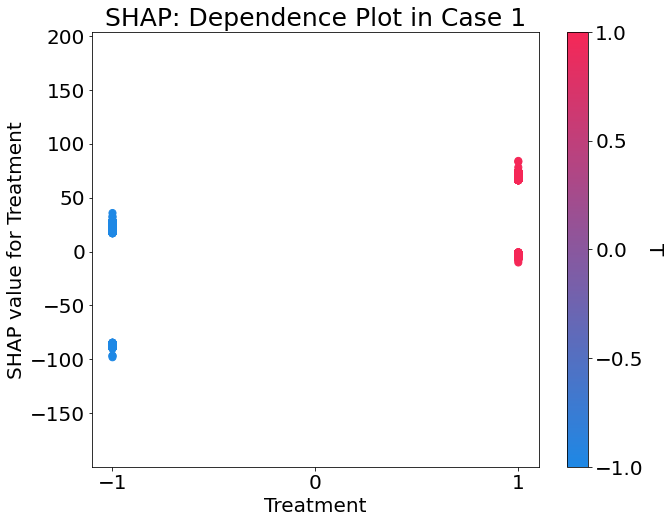

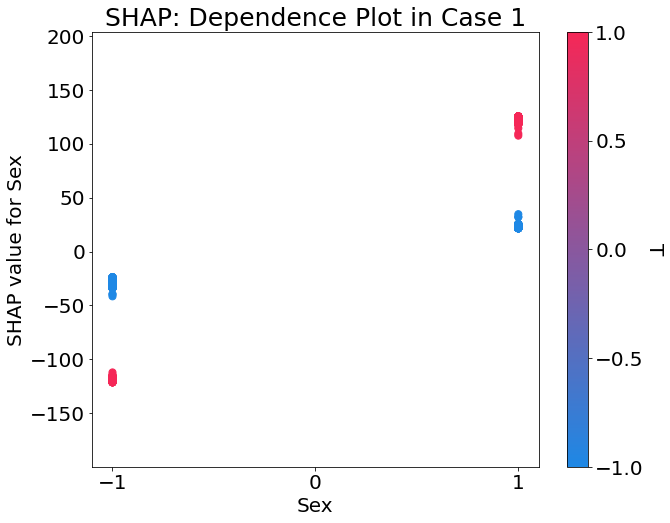

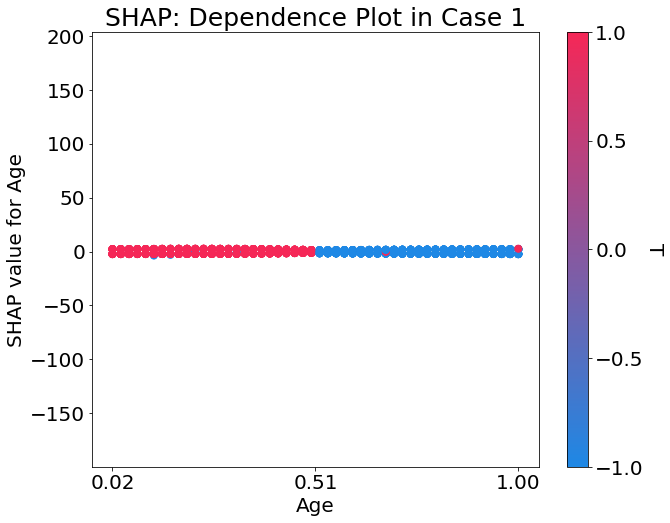

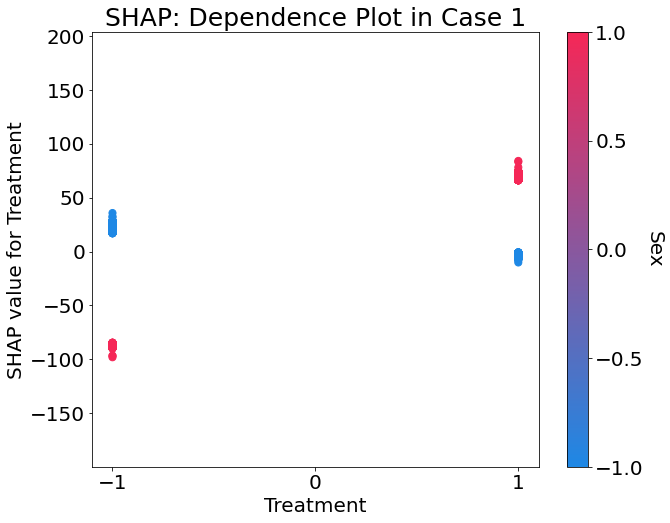

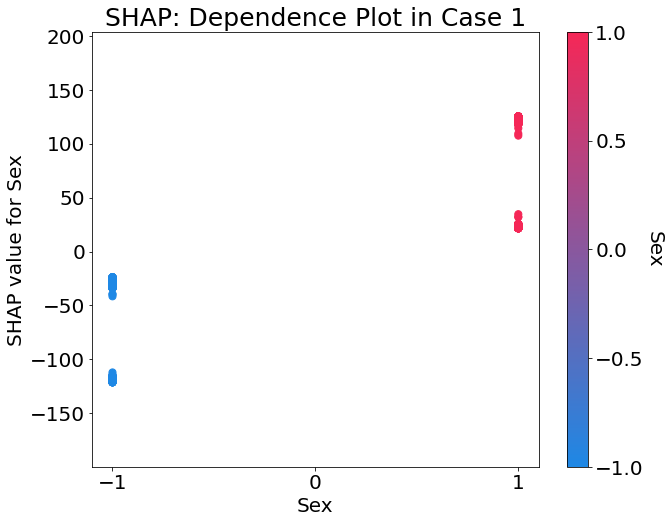

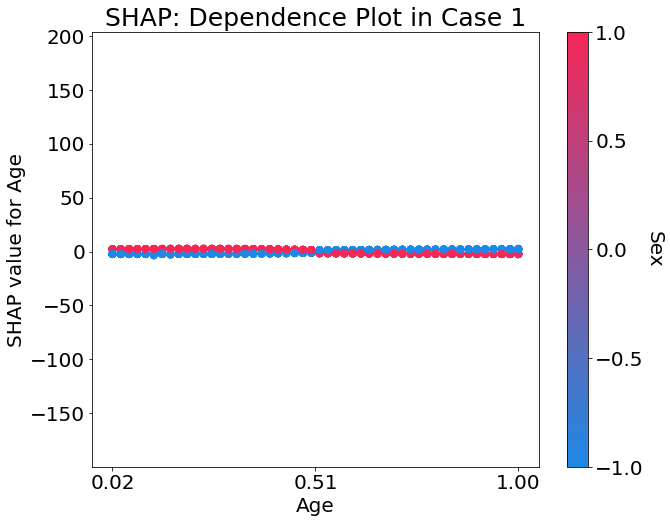

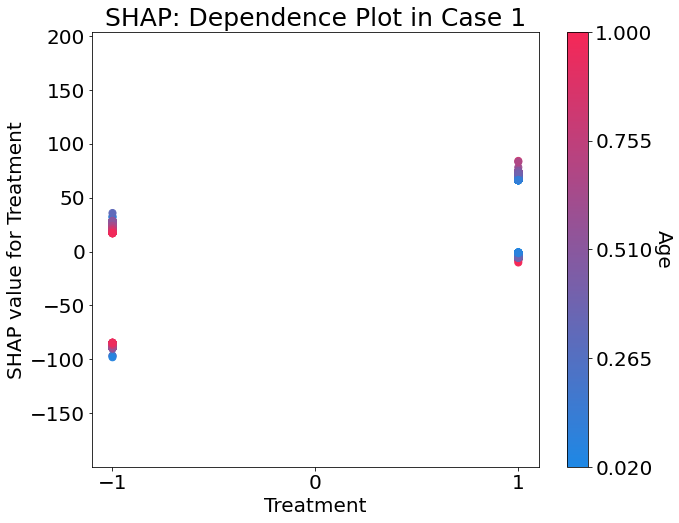

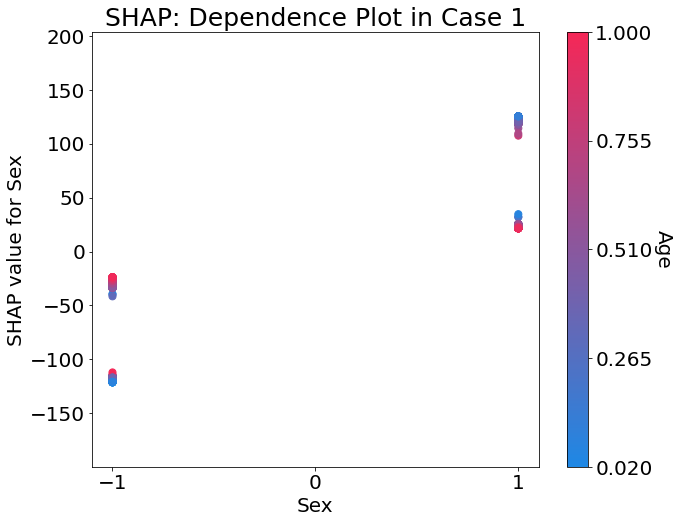

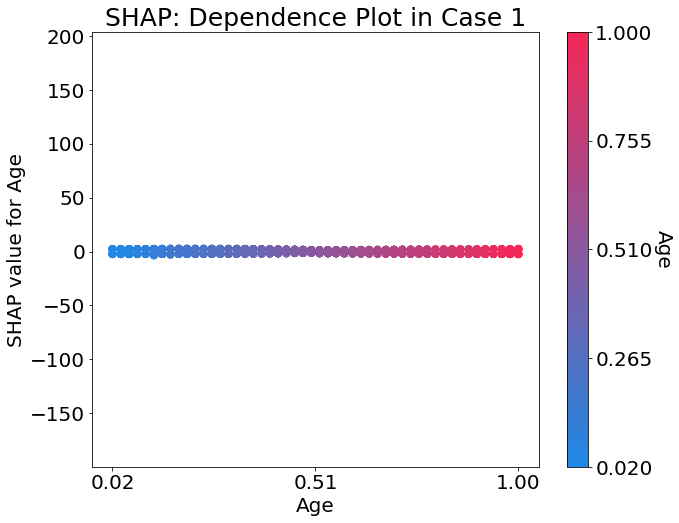

In [12]:
title = "SHAP: Dependence Plot in Case {}".format(caseType)
for cbarIdx in range(0, 3):
    dependence_plot(0, features, shap_values, cbarIdx=cbarIdx, featureName='Treatment', title=title)
    dependence_plot(1, features, shap_values, cbarIdx=cbarIdx, featureName='Sex', title=title)
    dependence_plot(2, features, shap_values, cbarIdx=cbarIdx, featureName='Age', title=title)

In [13]:
#np.save('shapValue/shapValueCase{}_{}.npy'.format(caseType, txtSubname), shap_values)